In [1]:
%load_ext autoreload
%autoreload 2

from einops import rearrange
from text3d2video.wandb_util import MVFeaturesArtifact
import wandb
import torch

/home/jorge/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from text3d2video.wandb_util import AnimationArtifact, first_logged_artifact_of_type, first_used_artifact_of_type


api = wandb.Api({
    'entity': 'romeu',
    'project': 'diffusion-3D-features'
})

mv_features_art = 'multiview_features:latest'

mv_features_art = api.artifact(f'romeu/diffusion-3D-features/{mv_features_art}')
mv_features_art = MVFeaturesArtifact(mv_features_art)

mv_featuers_run = mv_features_art.artifact.logged_by()
animation_art = first_used_artifact_of_type(mv_featuers_run, AnimationArtifact.type)
animation_art = AnimationArtifact(animation_art)

mesh = animation_art.get_mesh()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   19 of 19 files downloaded.  
wandb: Downloading large artifact backflip:v0, 121.09MB. 61 files... 
wandb:   61 of 61 files downloaded.  
Done. 0:0:0.4
/home/jorge/miniconda3/envs/thesis/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


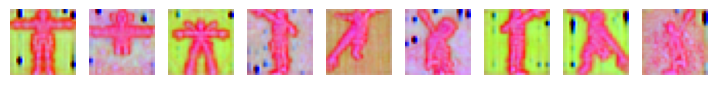

In [140]:
from matplotlib import pyplot as plt
from text3d2video.visualization import RgbPcaUtil

features = mv_features_art.get_features()
all_features = torch.stack(features)

all_features = rearrange(all_features, 'v c h w -> (v h w) c')
pca = RgbPcaUtil(all_features.shape[1])
pca.fit(all_features)

features_rgb = [pca.feature_map_to_rgb(feature) for feature in features]

cams = mv_features_art.get_cameras()

N = len(features_rgb)
scale = 1
fig, axs = plt.subplots(1, N, figsize=(scale*N, scale))
for i in range(N):
    axs[i].imshow(features_rgb[i].permute(1,2,0))
    axs[i].axis('off')

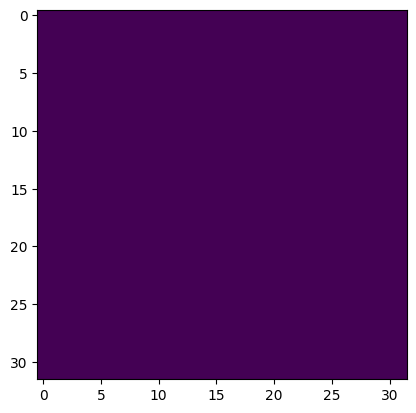

In [141]:
i = 1
greater = features_rgb[i] > 1
lower = features_rgb[i] < 0
both = greater | lower
both = both.any(dim=0)

plt.imshow(both)


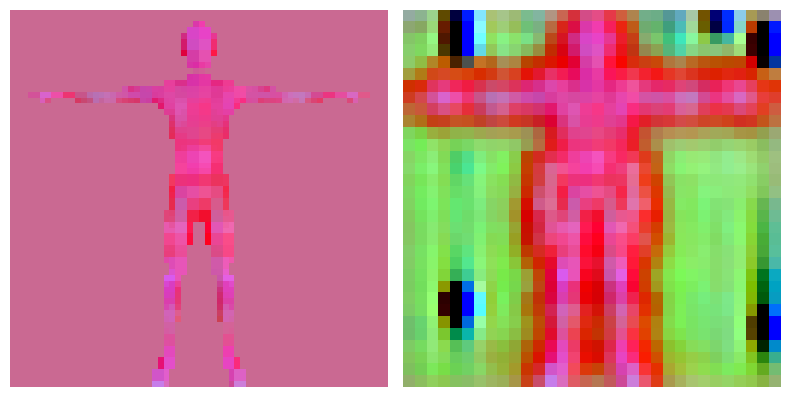

In [123]:
from text3d2video.rendering import make_rasterizer, rasterize_vertex_features
from text3d2video.util import project_vertices_to_features

feature_map = features[0]
cam = cams[0]
resolution = feature_map.shape[-1] * 2

vert_features = project_vertices_to_features(mesh, cam, feature_map)

feature_im = rasterize_vertex_features(cams[0], mesh, resolution, vert_features).cpu()

feature_im_rgb = pca.feature_map_to_rgb(feature_im.cpu())
feature_map_rgb = pca.feature_map_to_rgb(feature_map.cpu())

scale = 8
fig, axs = plt.subplots(1, 2, figsize=(scale, scale))
axs[0].imshow(feature_im_rgb.permute(1,2,0))
axs[1].imshow(feature_map_rgb.permute(1,2,0))

for ax in axs:
    ax.axis('off')

fig.tight_layout()